In [2]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Matern12_Model, Poisson_Model_T, SafeMatern32_Model, ST_Model, All_Matern_Model, Poisson_Model
import seaborn as sns
%matplotlib inline


sns.set()
sns.set_style('white')

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_csv('../data/gp_cut_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.DATE_IND = data.DATE_IND / 100
data.x_point = data.x_point / 100
data.y_point = data.y_point / 100

mean_e = data.groupby('DATETIME')['COUNT'].sum().loc['2015-01-01':'2015-12-31'].mean()

e_s = ((mean_e) / data.GRID_SQUARE.max()) # 5.36 is 2016 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.615384615385


In [9]:
search_periods = [[6,12]]

Beginning run [6, 12] : 
Training ends on: 2017-05-14 00:00:00
testing ends on: 2017-08-06 00:00:00
Initial neg. log-likelihood: -1496.14279985
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 303.473904
  Number of iterations: 537
  Number of functions evaluations: 592
Using kernel component Sum
added gp pred and error to test
gp_sq_error    1.272358
0              3.459350
dtype: float64


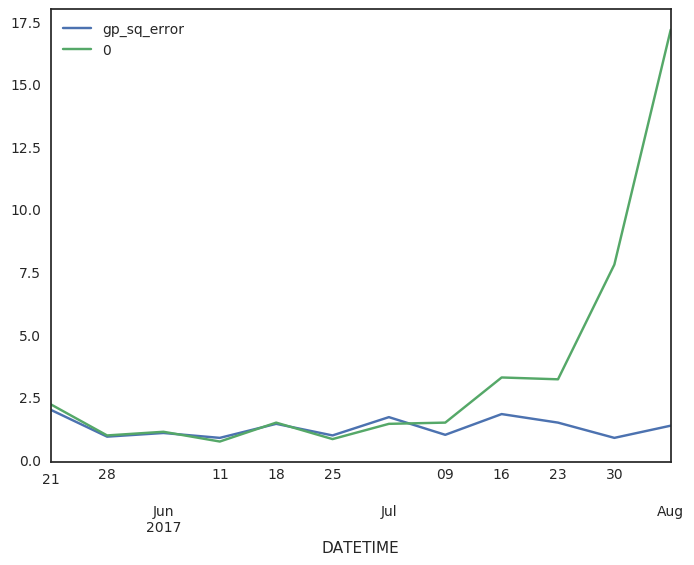

In [32]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2017/4/02', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s, period = 1, partial = True)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1000)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


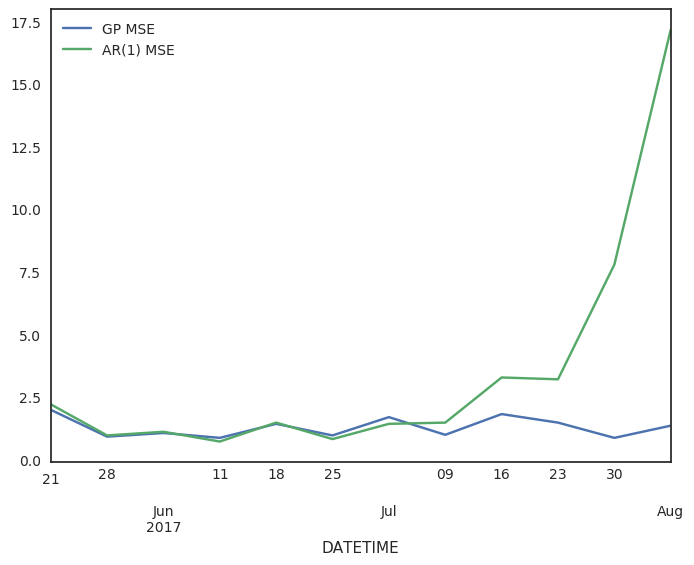

In [51]:
summary.plot()
plt.legend(['GP MSE','AR(1) MSE'])

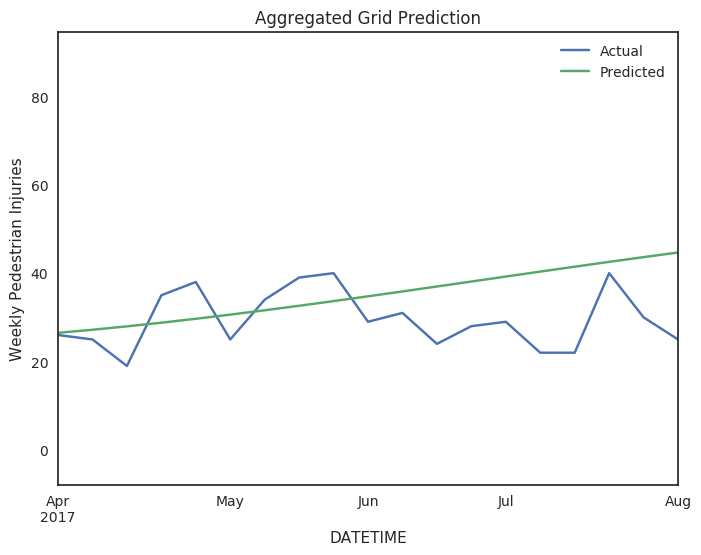

In [52]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train = data_dict['train']
train['gp_pred'] = pred_train[0]
train['gp_var'] = pred_train[1]

test = data_dict['test']
test['gp_pred'] = pred_test[0]
test['gp_var'] = pred_test[1]


pred = train.append(test)[['GRID_SQUARE','DATE_IND','COUNT','gp_pred','gp_var']]

pred['gp_err'] = np.sqrt(pred.gp_var)
pred['err_upper'] = pred.gp_pred + np.sqrt(pred.gp_var) * .95
pred['err_lower'] = pred.gp_pred - np.sqrt(pred.gp_var) * .95
pred['e_err'] = pred.COUNT - e_s

gb = pred.groupby('DATETIME').sum()
p = gb[['COUNT','gp_pred']].plot()
plt.plot(gb.err_lower, linestyle = ':', color = 'black', linewidth = 1)
plt.ylabel('Weekly Pedestrian Injuries')
plt.legend(['Actual','Predicted'])
plt.plot(gb.err_upper, linestyle = '-', color = 'black', linewidth = 1)
plt.title('Aggregated Grid Prediction')


In [55]:
X = np.vstack((data_dict['X_train'],(data_dict['X_test']) ))
y = np.vstack((data_dict['y_train'],(data_dict['y_test']) ))


pred['f_pred'] = m.predict_f(X)[0] 
pred['y_pred'] = m.predict_y(X)[0] 
pred['exp_f_pred'] = np.exp(pred['f_pred'])

pred['mu_rbf1'], _ = m.predict_f_rbf1(X)
pred['mu_rbf2'], _ = m.predict_f_rbf2(X)
pred['mu_periodic'], _ = m.predict_f_periodic(X)
pred['mu_product'], _ = m.predict_f_product(X)
pred['mu_combined'] = pred['mu_rbf1'] + pred['mu_rbf2'] + pred['mu_periodic'] + pred['mu_product']



In [56]:
pred.groupby('GRID_SQUARE')['exp_f_pred'].mean().to_csv('files/grid_square_f_scores.csv')

In [57]:
pred.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

GRID_SQUARE
29.0    86.0
30.0    38.0
39.0    36.0
31.0    30.0
8.0     27.0
Name: COUNT, dtype: float64

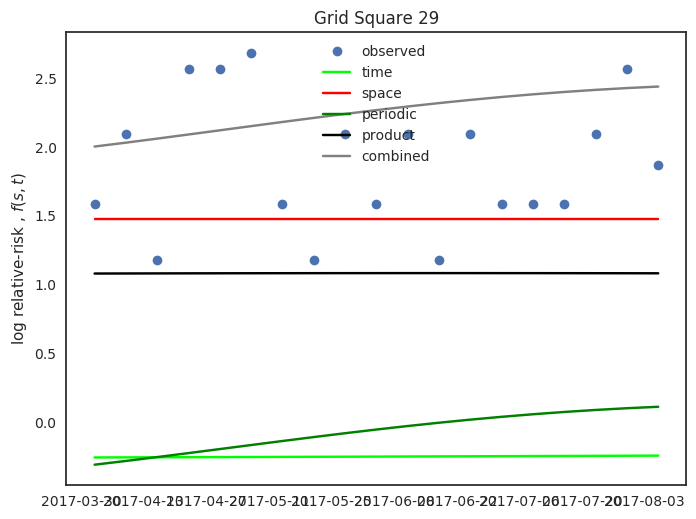

In [58]:
area = 29

nb = pred[pred.GRID_SQUARE == area].copy()

idx = nb.index.values
observed = np.log(nb['COUNT'] / e_s)
plt.plot(idx,observed,'o', label = 'observed')
plt.plot(idx, nb['mu_rbf1'] ,'lime',label = 'time')
plt.plot(idx, nb['mu_rbf2'], 'red' ,label='space')
plt.plot(idx, nb['mu_periodic'], 'green', label='periodic')
plt.plot(idx, nb['mu_product'], 'black',label='product')
plt.plot(idx, nb['f_pred'], 'grey',label='combined')

plt.legend()
plt.ylabel('log relative-risk , $f(s,t)$')
plt.title('Grid Square {}'.format(area))

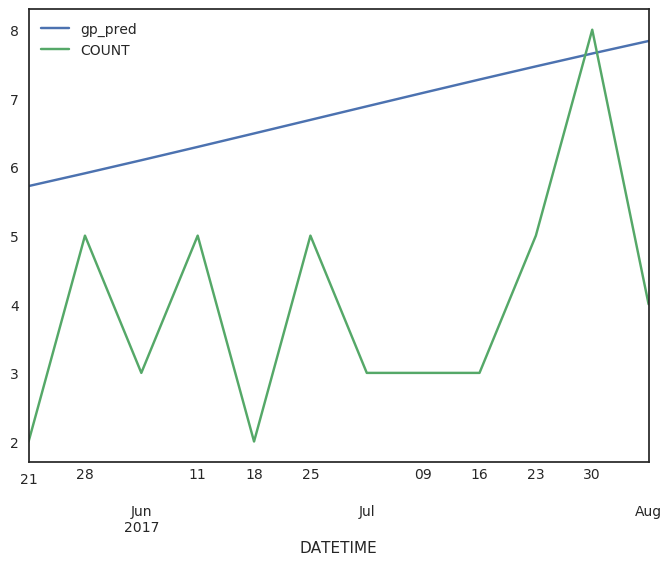

In [38]:
test[test.GRID_SQUARE == 29][['gp_pred','COUNT']].plot()

In [49]:
## Reduction in variance

def calc_var_reduction(c):
    return 1 - (np.square(pred[c]-pred.COUNT).sum() / np.square(pred[['e_err']]).sum())

calc_var_reduction('gp_pred')



e_err    0.27389
dtype: float64

In [50]:

for c in pred.filter(regex='mu_',axis =1):
    pred['pred_{}'.format(c)] = np.exp(pred[c]) * e_s
    print(c)
    print(calc_var_reduction('pred_{}'.format(c)))


mu_rbf1
e_err   -0.034888
dtype: float64
mu_rbf2
e_err    0.356063
dtype: float64
mu_periodic
e_err   -0.011411
dtype: float64
mu_product
e_err    0.261194
dtype: float64
mu_combined
e_err    0.320005
dtype: float64
